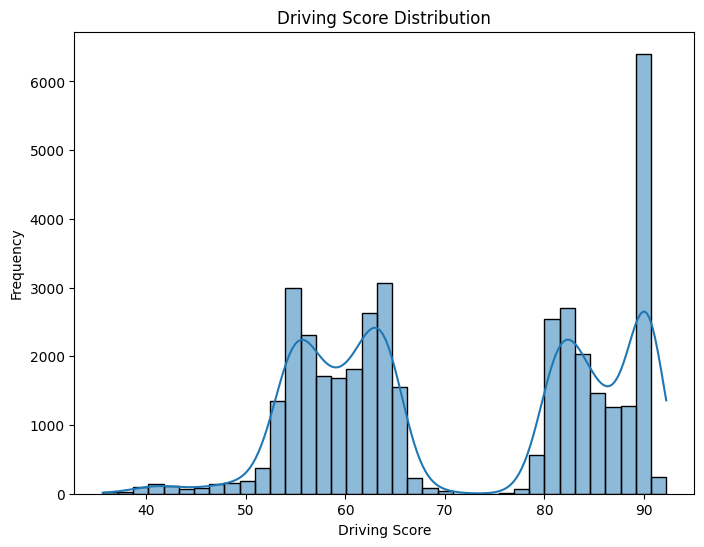

In [6]:
import os
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2, degrees
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Ensure the 'data' directory exists
output_directory = 'data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the driving data
df = pd.read_csv('../data/driving_data.csv')

# Ensure that Time_Step, Latitude, and Longitude are numeric
df['Time_Step'] = pd.to_numeric(df['Time_Step'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop rows with missing values in important columns
df = df.dropna(subset=['Time_Step', 'Latitude', 'Longitude'])

# Convert Speed from km/h to m/s
df['Speed(m/s)'] = df['Speed(km/h)'] * 0.27778

# Haversine formula to calculate distance between two GPS points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(d_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(d_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c * 1000  # Distance in meters

# Calculate differences for time, latitude, and longitude
df['Time_Diff'] = df['Time_Step'].diff().fillna(0)

# Shift latitude and longitude for distance calculation
df['Lat_Shifted'] = df['Latitude'].shift(1)
df['Lon_Shifted'] = df['Longitude'].shift(1)

# Calculate distance between consecutive points
df['Distance(m)'] = df.apply(lambda row: haversine(row['Lat_Shifted'], row['Lon_Shifted'], row['Latitude'], row['Longitude']), axis=1)

# Calculate acceleration (m/s²) and filter out extreme values (beyond ±10 m/s²)
df['Acceleration(m/s^2)'] = df['Speed(m/s)'].diff() / df['Time_Diff'].replace(0, np.nan).fillna(1)
df = df[df['Acceleration(m/s^2)'].between(-10, 10)]

# Calculate jerk (m/s³)
df['Jerk(m/s^3)'] = df['Acceleration(m/s^2)'].diff() / df['Time_Diff'].replace(0, np.nan).fillna(1)

# Calculate braking intensity (absolute value of negative acceleration)
df['Braking_Intensity'] = df['Acceleration(m/s^2)'].apply(lambda x: abs(x) if x < 0 else 0)

# Haversine formula for vectorized calculation
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c * 1000  # Distance in meters

# Load sensitive locations (school, hospital, etc.)
sensitive_locations = pd.read_csv('../data/sensitive_location.csv')

# Function to calculate SASV (Sensitive Area Speed Violation)
def calculate_sasv(lat, lon, speed, sensitive_locations):
    sensitive_distances = haversine_vectorized(lat, lon, sensitive_locations['Latitude'], sensitive_locations['Longitude'])
    if np.any(sensitive_distances < 300):  # Within 300 meters of sensitive areas
        if speed > 8.33:  # Speed > 30 km/h in sensitive area
            return 1
    return 0

# Apply SASV calculation
df['SASV'] = df.apply(lambda row: calculate_sasv(row['Latitude'], row['Longitude'], row['Speed(m/s)'], sensitive_locations), axis=1)

# Calculate rule violation score for exceeding general speed limit
def calculate_speed_violation(row):
    speed_limit = 13.89  # ~50 km/h general speed limit
    if row['Speed(m/s)'] > speed_limit:
        return 1  # Speed violation
    return 0

df['Speed_Violation'] = df.apply(calculate_speed_violation, axis=1)

# ---------- Driving Score Calculation with Rebalanced Weights and Heading Change ---------- #
# Initialize base score of 100 for each trip point
df['Driving_Score'] = 100

# Normalize the key features, including Heading_Change
scaler = MinMaxScaler()
df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity']] = scaler.fit_transform(
    df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity']])

# Apply rebalanced weighted penalties based on normalized features
df['Driving_Score'] -= df['Speed(m/s)'] * 25  # Speed penalty
df['Driving_Score'] -= df['Acceleration(m/s^2)'] * 15  # Acceleration penalty
df['Driving_Score'] -= df['Heading_Change(degrees)'] * 10  # Heading change penalty
df['Driving_Score'] -= df['Jerk(m/s^3)'] * 5  # Jerk penalty
df['Driving_Score'] -= df['Braking_Intensity'] * 5  # Braking intensity penalty

# Penalty for violations
df['Driving_Score'] -= df['SASV'] * 15  # Penalty for violating sensitive areas
df['Driving_Score'] -= df['Speed_Violation'] * 15 # Penalty for general speed violation

# Ensure the score is within the range [0, 100]
df['Driving_Score'] = df['Driving_Score'].clip(upper=100, lower=0)

# Driving Category based on score
def categorize_driving_score(score):
    if score > 80:
        return 'Safe'
    elif score > 60:
        return 'Moderate'
    else:
        return 'Risky'

df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving_score)

# Save the processed data
processed_columns = ['TripId', 'Time_Step', 'Latitude', 'Longitude', 'Speed(m/s)', 'Acceleration(m/s^2)', 
                     'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Braking_Intensity', 'SASV', 'Speed_Violation', 'Driving_Score', 'Driving_Category']
processed_data = df[processed_columns]
processed_data.to_csv('../data/processed_data.csv', index=False)

# ---------- Visualizations ---------- #

# 1. Distribution of Driving Scores
plt.figure(figsize=(8,6))
sns.histplot(df['Driving_Score'], kde=True)
plt.title("Driving Score Distribution")
plt.xlabel("Driving Score")
plt.ylabel("Frequency")
plt.show()

